# EDA of Metro HubNashville Dataset

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
##import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point

%matplotlib inline

## Read in HubNashville data file

In [2]:
hub_data = pd.read_csv('../data/hubNashville__311__Service_Requests.csv', low_memory = False)

## Read in Nashville zipcode data


In [3]:
zipcodes = gpd.read_file('../data/zipcodes.geojson')

In [4]:
zipcodes.crs = "EPSG:4326"

## My Questions
- what to do with nulls?
- fix date format?
- separate time from date column?


- longest open request?
- how quickly are most resolved?
- most common request type?
- what time do most requests come in?
- what month do most requests come in? 
- what council district has the most requests?    
- how many requests are made in a language other than English? No values in this column?  
- how many resolved the same day, in a week?
- how many escalated?
- What are the COVID-19 requests about?
- How has COVID-19 impacted (or will impact) public transportation? Animal control?

## Questions our team would like to answer:
- Trending requests: daily, weekly, monthly, yearly, time of day. Show most demanding requests trends daily, weekly, monthly... and show a comparison  over  the last 3 years, perhaps divide 24 hours into subsets. To possibly prepare for up coming request types and get an overview before digging deeper.
- Covid-19 impact (requests, violations) by council district
- Tornado impact - Hands On volunteers -- anything to improve for the next need?
- Parent requests - how many ‘child’ requests are added while the issue is unresolved.
- Average resolution time by type of request (this could be provided to people who make requests, so they have an ETA )


## Preliminary look at the data

In [5]:
hub_data.head()

Request #  Status    Request Type  \
0     353977  Closed        COVID-19   
1     354524  Closed  Quick Requests   
2     354188  Closed  Quick Requests   
3     354445  Closed  Quick Requests   
4     334893  Closed   Public Safety   

                                     Subrequest Type  \
0  COVID-19 - Submit Input about The Plan to Reop...   
1                                     Quick Requests   
2                                     Quick Requests   
3                                     Quick Requests   
4                  Control Number Request for Towing   

                          Additional Subrequest Type      Date / Time Opened  \
0  COVID-19 - Submit Input about The Plan to Reop...  04/28/2020 02:33:22 PM   
1                                                NaN  04/28/2020 09:46:53 PM   
2                                                NaN  04/28/2020 05:09:02 PM   
3                                                NaN  04/28/2020 08:50:36 PM   
4                                                NaN  03/29/2020 01:08:55 AM   

       Date / Time Closed          Request Origin System of Origin ID  \
0  04/28/2020 02:33:22 PM  hubNashville Community                 NaN   
1  04/28/2020 09:46:53 PM                   Phone                 NaN   
2  04/28/2020 05:09:02 PM                   Phone                 NaN   
3  04/28/2020 08:50:36 PM                   Phone                 NaN   
4  03/29/2020 01:08:55 AM  hubNashville Community                 NaN   

  Contact Type  ...  State Issue  Parent Request  Closed When Created  \
0          NaN  ...        False             NaN                 True   
1          NaN  ...        False             NaN                 True   
2          NaN  ...        False             NaN                 True   
3          NaN  ...        False             NaN                 True   
4          NaN  ...        False             NaN                 True   

                              Address            City Council District    ZIP  \
0                                 NaN             NaN              NaN    NaN   
1                                 NaN             NaN              NaN    NaN   
2                                 NaN             NaN              NaN    NaN   
3                                 NaN             NaN              NaN    NaN   
4  Long Hollow Pike & Northcreek Blvd  GOODLETTSVILLE             10.0  37072   

   Latitude  Longitude                 Mapped Location  
0       NaN        NaN                             NaN  
1       NaN        NaN                             NaN  
2       NaN        NaN                             NaN  
3       NaN        NaN                             NaN  
4  36.32619 -86.700618  (36.32619, -86.70061799999999)  

[5 rows x 21 columns]

In [6]:
hub_data.shape

(348671, 21)

In [7]:
hub_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348671 entries, 0 to 348670
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Request #                   348671 non-null  int64  
 1   Status                      348671 non-null  object 
 2   Request Type                348603 non-null  object 
 3   Subrequest Type             338024 non-null  object 
 4   Additional Subrequest Type  180510 non-null  object 
 5   Date / Time Opened          348671 non-null  object 
 6   Date / Time Closed          338424 non-null  object 
 7   Request Origin              348671 non-null  object 
 8   System of Origin ID         26398 non-null   object 
 9   Contact Type                26129 non-null   object 
 10  Preferred Language          0 non-null       float64
 11  State Issue                 348671 non-null  bool   
 12  Parent Request              3589 non-null    float64
 13  Closed When Cr

## Sort values by when request was opened

In [8]:
hub_data.sort_values(by = 'Date / Time Opened')

Request #  Status                Request Type  \
317237      35966  Closed   Trash, Recycling & Litter   
315401      35967  Closed   Trash, Recycling & Litter   
327939      35968  Closed   Trash, Recycling & Litter   
323146      35969  Closed   Trash, Recycling & Litter   
318265      35970  Closed   Trash, Recycling & Litter   
...           ...     ...                         ...   
75878      286840  Closed         Property Violations   
77255      286841  Closed         Property Violations   
80594      286842  Closed  Streets, Roads & Sidewalks   
68533      286843  Closed  Streets, Roads & Sidewalks   
67051      286844  Closed                     Transit   

                 Subrequest Type              Additional Subrequest Type  \
317237              Cart Service           Trash - Report a Damaged Cart   
315401  Recycling Drop Off Sites                                     NaN   
327939              Cart Service      Trash - Request an Additional Cart   
323146              Cart Service  Recycling - Request an Additional Cart   
318265              Cart Service  Recycling - Request an Additional Cart   
...                          ...                                     ...   
75878            Junk and Debris                                     NaN   
77255            Junk and Debris                                     NaN   
80594         Roadwork Complaint                                     NaN   
68533            Street Lighting                           Report Outage   
67051               State Routes                                     NaN   

            Date / Time Opened      Date / Time Closed  \
317237  01/01/2018 02:53:00 PM  01/03/2018 03:02:00 PM   
315401  01/01/2018 03:08:00 PM  01/02/2018 08:51:00 AM   
327939  01/01/2018 03:14:00 PM  04/17/2018 04:00:00 AM   
323146  01/01/2018 03:55:00 PM  01/10/2018 04:04:00 AM   
318265  01/01/2018 04:44:00 PM  01/04/2018 04:02:00 AM   
...                        ...                     ...   
75878   12/31/2019 12:37:00 AM  01/24/2020 08:09:00 AM   
77255   12/31/2019 12:40:00 AM  01/31/2020 08:08:00 AM   
80594   12/31/2019 12:41:00 AM  01/06/2020 05:10:00 PM   
68533   12/31/2019 12:43:00 AM  01/09/2020 03:32:00 PM   
67051   12/31/2019 12:45:00 AM  01/21/2020 05:40:00 PM   

                Request Origin System of Origin ID Contact Type  ...  \
317237  hubNashville Community                 NaN     Resident  ...   
315401  hubNashville Community                 NaN     Resident  ...   
327939  hubNashville Community                 NaN     Resident  ...   
323146  hubNashville Community                 NaN     Resident  ...   
318265  hubNashville Community                 NaN     Resident  ...   
...                        ...                 ...          ...  ...   
75878               Mobile App                 NaN          NaN  ...   
77255               Mobile App                 NaN          NaN  ...   
80594   hubNashville Community                 NaN          NaN  ...   
68533               Mobile App                 NaN          NaN  ...   
67051               Mobile App                 NaN          NaN  ...   

        State Issue  Parent Request  Closed When Created  \
317237        False             NaN                 True   
315401        False             NaN                 True   
327939        False             NaN                 True   
323146        False             NaN                 True   
318265        False             NaN                 True   
...             ...             ...                  ...   
75878         False             NaN                False   
77255         False             NaN                False   
80594         False             NaN                False   
68533         False             NaN                False   
67051         False             NaN                False   

                            Address       City Council District    ZIP  \
317237            1015 Maplewood Pl  NASHVILLE       

## Looked at null values

In [9]:
mapped_loc_nulls= hub_data['Mapped Location'].isnull()

In [10]:
mapped_loc_nulls

0          True
1          True
2          True
3          True
4         False
          ...  
348666    False
348667    False
348668    False
348669    False
348670    False
Name: Mapped Location, Length: 348671, dtype: bool

In [11]:
mapped_loc_nulls.value_counts()

False    284188
True      64483
Name: Mapped Location, dtype: int64

## Convert  time Opened and Closed to DateTime

In [12]:
t1 = pd.to_datetime(hub_data['Date / Time Opened'])
t2 = pd.to_datetime(hub_data['Date / Time Closed'])
hub_data['time_taken'] = t1-t2
# move time_taken column to after time_closed
col_name = 'time_taken'
hub_time = hub_data.pop(col_name)
hub_data.insert(7, col_name, hub_time)


In [13]:
hub_data['Date / Time Opened'] = pd.to_datetime(hub_data['Date / Time Opened'])

In [14]:
hub_data['Date / Time Closed'] = pd.to_datetime(hub_data['Date / Time Closed'])

In [15]:
hub_data.head(5)

Request #  Status    Request Type  \
0     353977  Closed        COVID-19   
1     354524  Closed  Quick Requests   
2     354188  Closed  Quick Requests   
3     354445  Closed  Quick Requests   
4     334893  Closed   Public Safety   

                                     Subrequest Type  \
0  COVID-19 - Submit Input about The Plan to Reop...   
1                                     Quick Requests   
2                                     Quick Requests   
3                                     Quick Requests   
4                  Control Number Request for Towing   

                          Additional Subrequest Type  Date / Time Opened  \
0  COVID-19 - Submit Input about The Plan to Reop... 2020-04-28 14:33:22   
1                                                NaN 2020-04-28 21:46:53   
2                                                NaN 2020-04-28 17:09:02   
3                                                NaN 2020-04-28 20:50:36   
4                                                NaN 2020-03-29 01:08:55   

   Date / Time Closed time_taken          Request Origin System of Origin ID  \
0 2020-04-28 14:33:22     0 days  hubNashville Community                 NaN   
1 2020-04-28 21:46:53     0 days                   Phone                 NaN   
2 2020-04-28 17:09:02     0 days                   Phone                 NaN   
3 2020-04-28 20:50:36     0 days                   Phone                 NaN   
4 2020-03-29 01:08:55     0 days  hubNashville Community                 NaN   

   ... State Issue  Parent Request  Closed When Created  \
0  ...       False             NaN                 True   
1  ...       False             NaN                 True   
2  ...       False             NaN                 True   
3  ...       False             NaN                 True   
4  ...       False             NaN                 True   

                              Address            City Council District    ZIP  \
0                                 NaN             NaN              NaN    NaN   
1                                 NaN             NaN              NaN    NaN   
2                                 NaN             NaN              NaN    NaN   
3                                 NaN             NaN              NaN    NaN   
4  Long Hollow Pike & Northcreek Blvd  GOODLETTSVILLE             10.0  37072   

   Latitude  Longitude                 Mapped Location  
0       NaN        NaN                             NaN  
1       NaN        NaN                             NaN  
2       NaN        NaN                             NaN  
3       NaN        NaN                             NaN  
4  36.32619 -86.700618  (36.32619, -86.70061799999999)  

[5 rows x 22 columns]

## Create a 'Year Requested' column

In [16]:
##hub_data[['Year Requested']] = hub_data['Date / Time Opened'].str.split('-', n=1, expand=True)
##df['date'] = pd.to_datetime(df['date'])
##df['year'], df['month'] = df['date'].dt.year, df['date'].dt.month

hub_data['Year Requested'] = hub_data['Date / Time Opened'].dt.year

In [17]:
hub_data.head()

Request #  Status    Request Type  \
0     353977  Closed        COVID-19   
1     354524  Closed  Quick Requests   
2     354188  Closed  Quick Requests   
3     354445  Closed  Quick Requests   
4     334893  Closed   Public Safety   

                                     Subrequest Type  \
0  COVID-19 - Submit Input about The Plan to Reop...   
1                                     Quick Requests   
2                                     Quick Requests   
3                                     Quick Requests   
4                  Control Number Request for Towing   

                          Additional Subrequest Type  Date / Time Opened  \
0  COVID-19 - Submit Input about The Plan to Reop... 2020-04-28 14:33:22   
1                                                NaN 2020-04-28 21:46:53   
2                                                NaN 2020-04-28 17:09:02   
3                                                NaN 2020-04-28 20:50:36   
4                                                NaN 2020-03-29 01:08:55   

   Date / Time Closed time_taken          Request Origin System of Origin ID  \
0 2020-04-28 14:33:22     0 days  hubNashville Community                 NaN   
1 2020-04-28 21:46:53     0 days                   Phone                 NaN   
2 2020-04-28 17:09:02     0 days                   Phone                 NaN   
3 2020-04-28 20:50:36     0 days                   Phone                 NaN   
4 2020-03-29 01:08:55     0 days  hubNashville Community                 NaN   

   ... Parent Request  Closed When Created  \
0  ...            NaN                 True   
1  ...            NaN                 True   
2  ...            NaN                 True   
3  ...            NaN                 True   
4  ...            NaN                 True   

                              Address            City  Council District  \
0                                 NaN             NaN               NaN   
1                                 NaN             NaN               NaN   
2                                 NaN             NaN               NaN   
3                                 NaN             NaN               NaN   
4  Long Hollow Pike & Northcreek Blvd  GOODLETTSVILLE              10.0   

     ZIP  Latitude  Longitude                 Mapped Location  Year Requested  
0    NaN       NaN        NaN                             NaN            2020  
1    NaN       NaN        NaN                             NaN            2020  
2    NaN       NaN        NaN                             NaN            2020  
3    NaN       NaN        NaN                             NaN            2020  
4  37072  36.32619 -86.700618  (36.32619, -86.70061799999999)            2020  

[5 rows x 23 columns]

## Look at counts in RequestType column

In [18]:
hub_data['Request Type'].value_counts()

Trash, Recycling & Litter     145146
Streets, Roads & Sidewalks     84830
Quick Requests                 64659
Property Violations            20651
Public Safety                   9733
COVID-19                        5246
Other                           4814
Electric & Water General        4354
Transit                         3692
Hands On Volunteers             2637
Permits                         1322
Parks                           1070
Planning & Zoning                250
Storm Relief                     167
Education & Libraries             22
Workforce & Jobs                   8
Public Records Request             2
Name: Request Type, dtype: int64

In [89]:
print(hub_data['Subrequest Type'].value_counts())

Quick Requests                             54141
Cart Service                               38339
Missed Pickup - Trash Cart Service         26338
Missed Pickup - Recycle Cart Service       19381
File a Trash or Recycling Complaint        16511
                                           ...  
WeGo Access                                    1
Pet Adoption                                   1
Library Locations                              1
Sign Signal Repairs                            1
Request Fire Truck for Event Appearance        1
Name: Subrequest Type, Length: 185, dtype: int64


## Look at counts in Status column

In [20]:
hub_data['Status'].value_counts()

Closed         338421
In Progress      6510
New              2509
Assigned          894
Transferred       315
On Hold            17
Denied              2
Completed           1
Escalated           1
In Process          1
Name: Status, dtype: int64

## Isolated COVID-19 requests

In [21]:
covid_19_req = hub_data[hub_data['Request Type'] == 'COVID-19']
covid_19_req

Request #  Status Request Type  \
0         353977  Closed     COVID-19   
5         334780  Closed     COVID-19   
38        334789  Closed     COVID-19   
44        346122  Closed     COVID-19   
66        354331  Closed     COVID-19   
...          ...     ...          ...   
49539     366206     New     COVID-19   
49552     366061     New     COVID-19   
49576     366040     New     COVID-19   
49601     365070     New     COVID-19   
49608     365064     New     COVID-19   

                                         Subrequest Type  \
0      COVID-19 - Submit Input about The Plan to Reop...   
5                                     COVID-19 Questions   
38                                    COVID-19 Questions   
44                                   COVID-19 Violations   
66                                    COVID-19 Questions   
...                                                  ...   
49539                                COVID-19 Violations   
49552                                COVID-19 Violations   
49576                                 COVID-19 Questions   
49601                                COVID-19 Violations   
49608                                COVID-19 Violations   

                              Additional Subrequest Type  Date / Time Opened  \
0      COVID-19 - Submit Input about The Plan to Reop... 2020-04-28 14:33:22   
5                                                    NaN 2020-03-28 14:17:51   
38                                                   NaN 2020-03-28 14:58:01   
44                                   COVID-19 Violations 2020-04-15 11:33:26   
66                                                   NaN 2020-04-28 19:32:58   
...                                                  ...                 ...   
49539                                COVID-19 Violations 2020-05-12 22:32:57   
49552                                COVID-19 Violations 2020-05-12 20:30:52   
49576                                                NaN 2020-05-12 20:16:57   
49601                                COVID-19 Violations 2020-05-12 15:16:36   
49608                                COVID-19 Violations 2020-05-12 15:14:40   

       Date / Time Closed         time_taken          Request Origin  \
0     2020-04-28 14:33:22    0 days 00:00:00  hubNashville Community   
5     2020-03-28 23:35:56  -1 days +14:41:55  hubNashville Community   
38    2020-04-01 19:56:36  -5 days +19:01:25  hubNashville Community   
44    2020-04-16 14:55:01  -2 days +20:38:25  hubNashville Community   
66    2020-05-08 19:13:25 -10 days +00:19:33  hubNashville Community   
...                   ...                ...                     ...   
49539                 NaT                NaT  hubNashville Community   
49552                 NaT                NaT                   Phone   
49576                 NaT                NaT                   Phone   
49601                 NaT                NaT  hubNashville Community   
49608                 NaT                NaT                   Phone   

      System of Origin ID  ... Parent Request  Closed When Created  \
0                     NaN  ...            NaN                 True   
5                     NaN  ...            NaN                False   
38                    NaN  ...            NaN                False   
44                    NaN  ...            NaN                False   
66                    NaN  ...            NaN                False   
...                   ...  ...            ...                  ...   
49539                 NaN  ...            NaN                False   
49552                 NaN  ...            NaN                False   
49576                 NaN  ...            NaN                False   
49601                 NaN  ...            NaN                False   
49608                 NaN  ...            NaN                False   

                     Address       City  Council District    ZIP   Latitude  \
0                        NaN        NaN        

## Subset dataframe with Subrequest for 'Dead Animal Pickup'

In [22]:
animal_pickup = hub_data[(hub_data['Subrequest Type'].notnull())&(hub_data['Subrequest Type']=='Dead Animal Pickup')]

In [23]:
animal_pickup.shape

(5398, 23)

In [24]:
animal_pickup

Request #  Status                Request Type     Subrequest Type  \
76         343503  Closed  Streets, Roads & Sidewalks  Dead Animal Pickup   
224        357858  Closed  Streets, Roads & Sidewalks  Dead Animal Pickup   
263        343555  Closed  Streets, Roads & Sidewalks  Dead Animal Pickup   
842        330768  Closed  Streets, Roads & Sidewalks  Dead Animal Pickup   
865        343519  Closed  Streets, Roads & Sidewalks  Dead Animal Pickup   
...           ...     ...                         ...                 ...   
348540       2485  Closed  Streets, Roads & Sidewalks  Dead Animal Pickup   
348560       3706  Closed  Streets, Roads & Sidewalks  Dead Animal Pickup   
348617       3382  Closed  Streets, Roads & Sidewalks  Dead Animal Pickup   
348622        449  Closed  Streets, Roads & Sidewalks  Dead Animal Pickup   
348632       1902  Closed  Streets, Roads & Sidewalks  Dead Animal Pickup   

       Additional Subrequest Type  Date / Time Opened  Date / Time Closed  \
76              Integration Issue 2020-04-10 07:14:25 2020-04-10 16:17:52   
224                           NaN 2020-05-04 14:12:05 2020-05-04 16:24:59   
263                           NaN 2020-04-10 13:05:22 2020-04-10 16:18:43   
842                           NaN 2020-03-22 19:06:46 2020-03-23 17:20:18   
865             Integration Issue 2020-04-10 11:47:49 2020-04-10 16:16:29   
...                           ...                 ...                 ...   
348540                        NaN 2017-07-25 15:27:00 2017-07-28 08:31:00   
348560                        NaN 2017-08-01 08:08:00 2017-08-02 04:03:00   
348617                        NaN 2017-07-30 08:00:00 2017-08-01 10:07:00   
348622                        NaN 2017-07-17 14:55:00 2017-07-26 10:33:00   
348632                        NaN 2017-07-22 08:00:00 2017-07-25 20:43:00   

              time_taken          Request Origin System of Origin ID  ...  \
76     -1 days +14:56:33  hubNashville Community                 NaN  ...   
224    -1 days +21:47:06                   Phone                 NaN  ...   
263    -1 days +20:46:39                   Phone                 NaN  ...   
842    -1 days +01:46:28  hubNashville Community                 NaN  ...   
865    -1 days +19:31:20  hubNashville Community                 NaN  ...   
...                  ...                     ...                 ...  ...   
348540 -3 days +06:56:00                   Phone                 NaN  ...   
348560 -1 days +04:05:00                   Phone                 NaN  ...   
348617 -3 days +21:53:00                   Phone         OE-00021783  ...   
348622 -9 days +04:22:00                   Phone                 NaN  ...   
348632 -4 days +11:17:00                   Phone         OE-00020844  ...   

       Parent Request  Closed When Created                          Address  \
76                NaN                False  Dodson Chapel Rd & James Kay Ln   
224               NaN                False  W Trinity Ln & Buena Vista Pike   
263               NaN                False                  1018 40th Ave N   
842               NaN                False           2835 Brick Church Pike   
865               NaN                False            4037 Dodson Chapel Rd   
...               ...                  ...                              ...   
348540            NaN                 True            4300 Clarksville pike   
348560            NaN                 True         murphy rd  & acklen park   
348617            NaN                 True               2223 WOODMONT BLVD   
348622            NaN                 True    BELMONT BLVD & GREEN HILLS DR   
348632            NaN                 True            NICHOL LN  &  PAGE RD   

             City  Council District    ZIP   Latitude  Longitude  \
76      HERMITAGE              14.0  37076  36.178060 -86.613790   
224     NASHVILLE               2.0  37218  36.202473 -86.820510   
263     NASHVILLE              21.0  37209  36.162937 -86.836935   
842     NASH

## Subset dataframe with Subrequest for 'Debris'

In [25]:
debris_sub = hub_data[(hub_data['Subrequest Type'].notnull())&(hub_data['Subrequest Type']=='Debris')]

In [26]:
debris_sub.head()

Empty DataFrame
Columns: [Request #, Status, Request Type, Subrequest Type, Additional Subrequest Type, Date / Time Opened, Date / Time Closed, time_taken, Request Origin, System of Origin ID, Contact Type, Preferred Language, State Issue, Parent Request, Closed When Created, Address, City, Council District, ZIP, Latitude, Longitude, Mapped Location, Year Requested]
Index: []

[0 rows x 23 columns]

## Create a geometry column in primary dataframe

In [27]:
hub_data['geometry'] = hub_data.apply(lambda x: Point((float(x.Longitude), 
                                                         float(x.Latitude))), 
                                        axis=1)


In [28]:
hub_data_geo = gpd.GeoDataFrame(hub_data,  
                           geometry = hub_data['geometry'])
hub_data_geo

Request #  Status                Request Type  \
0          353977  Closed                    COVID-19   
1          354524  Closed              Quick Requests   
2          354188  Closed              Quick Requests   
3          354445  Closed              Quick Requests   
4          334893  Closed               Public Safety   
...           ...     ...                         ...   
348666       2699  Closed  Streets, Roads & Sidewalks   
348667       2214  Closed   Trash, Recycling & Litter   
348668        163  Closed   Trash, Recycling & Litter   
348669       3202  Closed  Streets, Roads & Sidewalks   
348670       1237  Closed  Streets, Roads & Sidewalks   

                                          Subrequest Type  \
0       COVID-19 - Submit Input about The Plan to Reop...   
1                                          Quick Requests   
2                                          Quick Requests   
3                                          Quick Requests   
4                       Control Number Request for Towing   
...                                                   ...   
348666                                           Potholes   
348667                                       Cart Service   
348668                 Missed Pickup - Trash Cart Service   
348669                         Overgrowth on right of way   
348670                         Overgrowth on right of way   

                               Additional Subrequest Type  Date / Time Opened  \
0       COVID-19 - Submit Input about The Plan to Reop... 2020-04-28 14:33:22   
1                                                     NaN 2020-04-28 21:46:53   
2                                                     NaN 2020-04-28 17:09:02   
3                                                     NaN 2020-04-28 20:50:36   
4                                                     NaN 2020-03-29 01:08:55   
...                                                   ...                 ...   
348666                                            Roadway 2017-07-26 14:54:00   
348667                      Trash - Report a Damaged Cart 2017-07-24 16:58:00   
348668               Trash - Curbside/Alley Missed Pickup 2017-07-17 07:12:00   
348669                                            Roadway 2017-07-28 10:07:00   
348670                                            Roadway 2017-07-20 07:44:00   

        Date / Time Closed         time_taken          Request Origin  \
0      2020-04-28 14:33:22    0 days 00:00:00  hubNashville Community   
1      2020-04-28 21:46:53    0 days 00:00:00                   Phone   
2      2020-04-28 17:09:02    0 days 00:00:00                   Phone   
3      2020-04-28 20:50:36    0 days 00:00:00                   Phone   
4      2020-03-29 01:08:55    0 days 00:00:00  hubNashville Community   
...                    ...                ...                     ...   
348666 2017-08-01 08:12:00  -6 days +06:42:00                   Phone   
348667 2017-08-09 04:06:00 -16 days +12:52:00                   Phone   
348668 2017-07-21 11:58:00  -5 days +19:14:00                   Phone   
348669 2017-08-15 04:02:00 -18 days +06:05:00                   Phone   
348670 2017-07-28 16:22:00  -9 days +15:22:00                   Phone   

       System of Origin ID  ... Closed When Created  \
0                      NaN  ...                True   
1                      NaN  ...                True   
2                      NaN  ...                True   
3                      NaN  ...                True   
4                      NaN  ...                True   
...                    ...  ...                 ...   
348666                 NaN  ...                True   
348667                 NaN  ...                True   
348668                 NaN  ...                True   
348669                 NaN  ...                True   
348670                 NaN  ...                True   

                                   Address            City  Council District  \

In [29]:
hub_data_geo.crs = "EPSG:4326"

In [30]:
print(hub_data_geo.crs)

EPSG:4326


In [31]:
type(hub_data_geo)

geopandas.geodataframe.GeoDataFrame

## Map COVID-19 by zip code = requests, violations,  questions
   ##  - Creating zipcode map with COVID-19 requests as points

In [32]:
covid_19_req['geometry'] = covid_19_req.apply(lambda x: Point((float(x.Longitude), 
                                                         float(x.Latitude))), 
                                        axis=1)
## .apply is a safe way to create a new column from existing columns, but take note of this error 

C:\Users\catherine schmalzer\Anaconda3\envs\geospatial\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
covid_19_geo = gpd.GeoDataFrame(covid_19_req,  
                           geometry = hub_data['geometry'])
covid_19_geo.head(5)

Request #  Status Request Type  \
0      353977  Closed     COVID-19   
5      334780  Closed     COVID-19   
38     334789  Closed     COVID-19   
44     346122  Closed     COVID-19   
66     354331  Closed     COVID-19   

                                      Subrequest Type  \
0   COVID-19 - Submit Input about The Plan to Reop...   
5                                  COVID-19 Questions   
38                                 COVID-19 Questions   
44                                COVID-19 Violations   
66                                 COVID-19 Questions   

                           Additional Subrequest Type  Date / Time Opened  \
0   COVID-19 - Submit Input about The Plan to Reop... 2020-04-28 14:33:22   
5                                                 NaN 2020-03-28 14:17:51   
38                                                NaN 2020-03-28 14:58:01   
44                                COVID-19 Violations 2020-04-15 11:33:26   
66                                                NaN 2020-04-28 19:32:58   

    Date / Time Closed         time_taken          Request Origin  \
0  2020-04-28 14:33:22    0 days 00:00:00  hubNashville Community   
5  2020-03-28 23:35:56  -1 days +14:41:55  hubNashville Community   
38 2020-04-01 19:56:36  -5 days +19:01:25  hubNashville Community   
44 2020-04-16 14:55:01  -2 days +20:38:25  hubNashville Community   
66 2020-05-08 19:13:25 -10 days +00:19:33  hubNashville Community   

   System of Origin ID  ... Closed When Created        Address       City  \
0                  NaN  ...                True            NaN        NaN   
5                  NaN  ...               False            NaN        NaN   
38                 NaN  ...               False            NaN        NaN   
44                 NaN  ...               False  928 6th Ave S  NASHVILLE   
66                 NaN  ...               False            NaN        NaN   

    Council District    ZIP  Latitude  Longitude  \
0                NaN    NaN       NaN        NaN   
5                NaN    NaN       NaN        NaN   
38               NaN    NaN       NaN        NaN   
44              17.0  37203  36.14904 -86.772273   
66               NaN    NaN       NaN        NaN   

                     Mapped Location Year Requested                geometry  
0                                NaN           2020         POINT (nan nan)  
5                                NaN           2020         POINT (nan nan)  
38                               NaN           2020         POINT (nan nan)  
44  (36.1490396, -86.77227289999999)           2020  POINT (-86.772 36.149)  
66                               NaN           2020         POINT (nan nan)  

[5 rows x 24 columns]

In [42]:
covid_19_geo = covid_19_geo.dropna(subset=['geometry', 'Longitude', 'Latitude'])
print(covid_19_geo.shape)

(2936, 24)


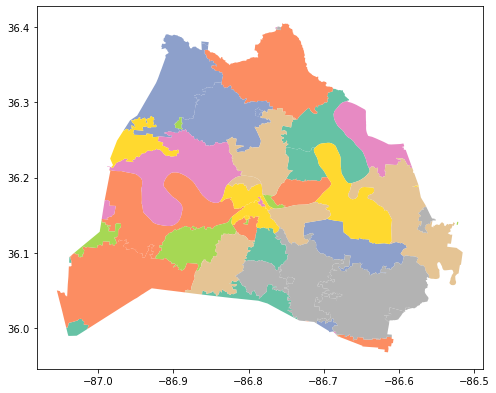

In [34]:
zipcodes.plot(figsize = (8, 10), cmap = 'Set2')

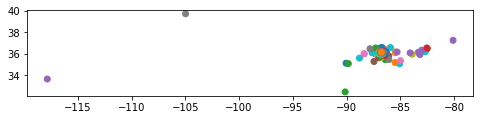

In [37]:
ax = zipcodes.plot(figsize = (8, 10), color = 'lightgreen')
covid_19_geo.plot( ax = ax, column = 'Address');
plt.show();

## COVID-19 Cluster Map

In [92]:
map_nash_cov = folium.Map(location = [36.1227, -86.8269] , zoom_start = 10)
marker_cluster = MarkerCluster().add_to(map_nash_cov)
folium.GeoJson(zipcodes).add_to(map_nash_cov)

#iterate through covid_19_geo to create locations and markers for each covid-related request

for row_index, row_values in covid_19_geo.iterrows():
    loc = [row_values['Latitude'], row_values['Longitude']]
    pop = str(row_values['Subrequest Type'])
    marker = folium.Marker(
        location = loc, 
        popup = pop) 
    
    marker.add_to(marker_cluster)
map_nash_cov.save('../maps/map_nash_cov.html')

#display our map
map_nash_cov

In [67]:
covid_19_geo.head()


Request #  Status Request Type      Subrequest Type  \
44      346122  Closed     COVID-19  COVID-19 Violations   
69      339374  Closed     COVID-19  COVID-19 Violations   
80      343513  Closed     COVID-19  COVID-19 Violations   
85      339423  Closed     COVID-19  COVID-19 Violations   
104     330774  Closed     COVID-19                  NaN   

    Additional Subrequest Type  Date / Time Opened  Date / Time Closed  \
44         COVID-19 Violations 2020-04-15 11:33:26 2020-04-16 14:55:01   
69         COVID-19 Violations 2020-04-04 18:13:59 2020-04-09 13:07:22   
80         COVID-19 Violations 2020-04-10 10:40:08 2020-04-14 19:39:09   
85         COVID-19 Violations 2020-04-04 20:12:27 2020-04-09 14:21:09   
104                        NaN 2020-03-22 19:12:44 2020-03-23 01:28:28   

           time_taken          Request Origin System of Origin ID  ...  \
44  -2 days +20:38:25  hubNashville Community                 NaN  ...   
69  -5 days +05:06:37  hubNashville Community                 NaN  ...   
80  -5 days +15:00:59  hubNashville Community                 NaN  ...   
85  -5 days +05:51:18  hubNashville Community                 NaN  ...   
104 -1 days +17:44:16  hubNashville Community                 NaN  ...   

    Closed When Created              Address       City  Council District  \
44                False        928 6th Ave S  NASHVILLE              17.0   
69                False     500 Gallatin Ave  NASHVILLE               5.0   
80                False  5720 Crossings Blvd        NaN               NaN   
85                False      5310 Mt View Rd    ANTIOCH              32.0   
104               False      10 Airways Blvd  NASHVILLE              13.0   

       ZIP   Latitude  Longitude                   Mapped Location  \
44   37203  36.149040 -86.772273  (36.1490396, -86.77227289999999)   
69   37206  36.181548 -86.749695           (36.181548, -86.749695)   
80     NaN  36.039608 -86.646541           (36.039608, -86.646541)   
85   37013  36.048182 -86.648447         (36.0481819, -86.6484474)   
104  37217  36.129860 -86.687690             (36.12986, -86.68769)   

    Year Requested                    geometry  
44            2020  POINT (-86.77227 36.14904)  
69            2020  POINT (-86.74969 36.18155)  
80            2020  POINT (-86.64654 36.03961)  
85            2020  POINT (-86.64845 36.04818)  
104           2020  POINT (-86.68769 36.12986)  

[5 rows x 24 columns]

## Use groupby to count Covid-19 Requests by zipcode

In [71]:
covid_by_zip = covid_19_geo.groupby(['ZIP']).count()

In [72]:
covid_by_zip.head()

Request #  Status  Request Type  Subrequest Type  \
ZIP                                                       
37013        169     169           169              169   
37027         13      13            13               13   
37036          1       1             1                1   
37040          1       1             1                1   
37064          4       4             4                4   

       Additional Subrequest Type  Date / Time Opened  Date / Time Closed  \
ZIP                                                                         
37013                         152                 169                 160   
37027                          12                  13                  12   
37036                           1                   1                   1   
37040                           1                   1                   1   
37064                           4                   4                   4   

       time_taken  Request Origin  System of Origin ID  ...  Parent Request  \
ZIP                                                     ...                   
37013         160             169                    0  ...               0   
37027          12              13                    0  ...               0   
37036           1               1                    0  ...               0   
37040           1               1                    0  ...               0   
37064           4               4                    0  ...               0   

       Closed When Created  Address  City  Council District  Latitude  \
ZIP                                                                     
37013                  169      167   168               168       169   
37027                   13       13    11                11        13   
37036                    1        1     0                 0         1   
37040                    1        1     0                 0         1   
37064                    4        4     0                 0         4   

       Longitude  Mapped Location  Year Requested  geometry  
ZIP                                                          
37013        169              169             169       169  
37027         13               13              13        13  
37036          1                1               1         1  
37040          1                1               1         1  
37064          4                4               4         4  

[5 rows x 23 columns]

In [74]:
covid_by_zip = covid_by_zip.reset_index()

## Delete columns for use in map

In [75]:
covid_by_zip = covid_by_zip[['ZIP', 'Request Type']]
covid_by_zip.head()

ZIP  Request Type
0  37013           169
1  37027            13
2  37036             1
3  37040             1
4  37064             4

In [81]:
covid_by_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ZIP           51 non-null     object
 1   Request Type  51 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 944.0+ bytes


## Merge subset with zipcode dataframe

In [84]:
merge_by_zip = pd.merge(zipcodes, covid_by_zip, left_on = 'zip', right_on = 'ZIP')
type(merge_by_zip)

geopandas.geodataframe.GeoDataFrame

In [78]:
zipcodes.head()

zip objectid    po_name      shape_stlength        shape_starea  \
0  37115        1    MADISON  178783.02488886821  596553400.57885742   
1  37216        3  NASHVILLE  75820.997821400058  188884682.28344727   
2  37204        9  NASHVILLE  93180.292250425613  200664795.51708984   
3  37027       11  BRENTWOOD   159760.6942933173  174978422.04101562   
4  37064       18   FRANKLIN  28995.828320601937  46969608.005737305   

                                            geometry  
0  MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ...  
1  MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ...  
2  MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ...  
3  MULTIPOLYGON (((-86.81258 36.06319, -86.81263 ...  
4  MULTIPOLYGON (((-87.02197 36.01200, -87.02140 ...

In [80]:
zipcodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   zip             56 non-null     object  
 1   objectid        56 non-null     object  
 2   po_name         56 non-null     object  
 3   shape_stlength  56 non-null     object  
 4   shape_starea    56 non-null     object  
 5   geometry        56 non-null     geometry
dtypes: geometry(1), object(5)
memory usage: 2.8+ KB


## COVID-19 Quantitative Map of Requests per Zipcode

In [96]:
chloro_nash_cov = folium.Map(location=[36.1227, -86.8269] , zoom_start = 10)
 

chloropleth = folium.Choropleth(
    geo_data=merge_by_zip,#polygons
    name='geometry',
    data=merge_by_zip,#used to color
    columns=['ZIP', 'Request Type'],
    key_on='feature.properties.zip',# the distinct column
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.8,
    legend_name='COVID-19 Requests'
).add_to(chloro_nash_cov)

folium.LayerControl().add_to(chloro_nash_cov)

# Display Zipcode Label
chloropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['zip'], labels=False)
)

chloro_nash_cov

## Bobcat 1
- Dead animal pickup and debris (for example) - make variable dataframes
- Count of dead animal pickup (or other categories), made histogram or other visual, count requests by zip 
- compare between different events (covid, tornado, control) and time of day. 
- Use this info to inform resource allocation.

## Bobcat 2
- Aggregate count of subrequest type by hour/month 
- How many of each (sub)request type are open at a given time to help staff forecast when heavy request load will occur.
- Consider dividing into 6hr chunks/bins for unit of analysis (morning, afternoon, evening, night)

## Bobcat 3
- Visualize geographical differences across time to completion/request type/other factors. 
- Identify spikes/outliers/trends across different dimensions (time/request type/volume/etc.). 
- Intention to help direct resources. Which area has the most activity to direct staff appropriately. 